In [1]:
import pandas as pd
import sqlite3
from pathlib import Path
import re
import numpy as np
from scipy.stats import skew
from funcz import *
import warnings
import copy
import duckdb
import ipywidgets as widgets
from IPython.display import display
warnings.filterwarnings('ignore')
engine = duckdb.connect('my_db.duckdb')

In [2]:
df = pd.read_sql(con=engine, sql='''


 -------------------------------------------------------------------------------------------------------------------
--Demographic Data
-------------------------------------------------------------------------------------------------------------------
WITH demo_cte AS (
  SELECT 
  dd.year, 
  dd.community_board,
  SUM(CASE WHEN dd.metric = 'Population' THEN dd.value ELSE 0 END) AS total_population,
  SUM(CASE WHEN dd.metric = 'Average Household Size' THEN dd.value ELSE 0 END) AS average_household_size,
  SUM(CASE WHEN dd.metric = 'White Population' THEN dd.value ELSE 0 END) / SUM(CASE WHEN dd.metric = 'Population' THEN dd.value ELSE 0 END) AS white_population,
  FROM demo_data dd 
  GROUP BY 1,2
),
-------------------------------------------------------------------------------------------------------------------
--Pop Data
-------------------------------------------------------------------------------------------------------------------
pop_data AS (
  SELECT 
  un.YEAR,
  un.community_board,
  un.unemployment_rate,
  rd.rent,
  inc.median_income/12 AS median_income
  FROM unemployment_rate_data un
  LEFT JOIN rent_data rd ON un.YEAR = rd.YEAR AND un.community_board = rd.community_board 
  LEFT JOIN (
      SELECT 
      inc.YEAR,
      inc.community_board,
      inc.median_income
      FROM median_income_data inc
  ) inc ON un.year = inc.YEAR AND un.community_board  = inc.community_board
),
-------------------------------------------------------------------------------------------------------------------
--Education Data on a DBN, Year Level
-------------------------------------------------------------------------------------------------------------------
education_data_dbn AS (
    SELECT DISTINCT
    CAST(split_part(sp.YEAR,'-',2) AS int) AS YEAR,
    sp.dbn,
    COALESCE(
      sp.score,
      AVG(score) OVER (PARTITION BY split_part(sp.YEAR, '-', 2), LEFT(sp.dbn, 3))
    ) AS score
    FROM school_performance sp
),
-------------------------------------------------------------------------------------------------------------------
--Education Data on a Community Board, Year Level
-------------------------------------------------------------------------------------------------------------------
education_data AS (
  SELECT
  split_part(sd.community_board,'.',1) AS community_board,
  ed.YEAR,
  AVG(score) AS score
  FROM education_data_dbn ed
  LEFT JOIN school_data sd ON ed.dbn = sd.dbn
  GROUP BY 1,2
),
-------------------------------------------------------------------------------------------------------------------
--Crime Data
-------------------------------------------------------------------------------------------------------------------
crime_data_CTE AS (
  SELECT community_board, year, SUM(crimes) AS crimes FROM (
  SELECT 
  pd.community_board, 
  pd.precinct,
  cd.YEAR,
  crimes/COUNT(community_board) OVER(PARTITION BY cd.YEAR,pd.precinct) AS crimes
  FROM precinct_data pd 
  LEFT JOIN (
    select
    cd.YEAR,
    cd.pct,
    SUM(count) AS crimes
    FROM crime_data cd
    WHERE crime_category IN ('major','non-major')
    GROUP BY 1,2
  ) cd ON pd.precinct  = cd.pct 
) sq GROUP BY 1,2
),
-------------------------------------------------------------------------------------------------------------------
--Base CTE
-------------------------------------------------------------------------------------------------------------------
base_CTE AS (
  SELECT 
  cb.community_board,
  unnest(ye.year) as year
  FROM community_board_data cb
  CROSS JOIN (SELECT generate_series(2006, 2024) AS YEAR) ye
)

SELECT 
b.community_board,
b.YEAR,
COALESCE(
  COALESCE(ed.score, AVG(ed.score) OVER (PARTITION BY b.community_board)),
  AVG(ed.score) OVER (PARTITION BY b.year),
  0.6
) AS grade_school_score,
cd.crimes,
total_population,
cd.crimes/total_population * 100000 AS crime_rate, 
CASE WHEN dc.white_population >= 0.51 THEN '1' ELSE '0' END AS white_majority,
dc.average_household_size,
pd.unemployment_rate,
pd.rent,
pd.median_income
FROM base_CTE b
LEFT JOIN education_data ed ON b.community_board = ed.community_board AND b.YEAR = ed.YEAR
LEFT JOIN demo_cte dc ON b.community_board = dc.community_board AND b.YEAR = dc.YEAR
LEFT JOIN crime_data_CTE cd ON b.community_board = cd.community_board AND b.YEAR = cd.YEAR 
LEFT JOIN pop_data pd ON b.community_board = pd.community_board AND b.YEAR = pd.YEAR




                      
                       
'''                        )


## 3.2.1: Feature Transformations:

In [3]:
stat_dude = StatWhiz(data=df, entity="community_board",time="year",dep="crime_rate")
stat_dude.plot_diagnostics()
stat_dude.plot_diagnostics(fix='y',skew_bound=0.85) 
stat_dude.zscore_standardize(columns=["average_household_size","crime_rate"])

## 3.2.2: Obtaining Interaction and Lagged Terms:

In [4]:
df = stat_dude.data.copy()
df = duckdb.query(''' 
SELECT * FROM (
SELECT 
community_board,
YEAR,
grade_school_score,
crime_rate, 
white_majority,
average_household_size,
unemployment_rate,
LAG(crime_rate) OVER(PARTITION BY community_board ORDER BY year) AS lag_crime_rate,
rent/median_income AS rent_proportion,
(unemployment_rate - LAG(unemployment_rate) OVER(PARTITION BY community_board ORDER BY year)) 
/ NULLIF(LAG(unemployment_rate) OVER(PARTITION BY community_board ORDER BY year), 0) AS unemployment_change,
(rent/median_income - (LAG(rent) OVER(PARTITION BY community_board ORDER BY year) / LAG(median_income) OVER(PARTITION BY community_board ORDER BY year)))
/ NULLIF((LAG(rent) OVER(PARTITION BY community_board ORDER BY year) / LAG(median_income) OVER(PARTITION BY community_board ORDER BY year)), 0) AS rent_proportion_change,
rent_proportion * unemployment_rate AS economic_hardship,
rent_proportion * average_household_size AS household_strain,
((rent/median_income - (LAG(rent) OVER(PARTITION BY community_board ORDER BY year) / LAG(median_income) OVER(PARTITION BY community_board ORDER BY year))) 
/ NULLIF((LAG(rent) OVER(PARTITION BY community_board ORDER BY year) / LAG(median_income) OVER(PARTITION BY community_board ORDER BY year)), 0))
* ((unemployment_rate - LAG(unemployment_rate) OVER(PARTITION BY community_board ORDER BY year)) 
/ NULLIF(LAG(unemployment_rate) OVER(PARTITION BY community_board ORDER BY year), 0)) AS economic_hardship_volatility

FROM df 
) WHERE year >= 2007                
''').to_df()
stat_dude.data["white_majority"] = stat_dude.data["white_majority"].astype(int)
stat_dude.data = df


## 3.2.4 Checking For Non Linear Relationships

In [5]:
stat_dude.plot_scatter_with_dep(n_cols=3)



## 3.2.4 Correlation and Multicollinearity (With Interaction Terms)


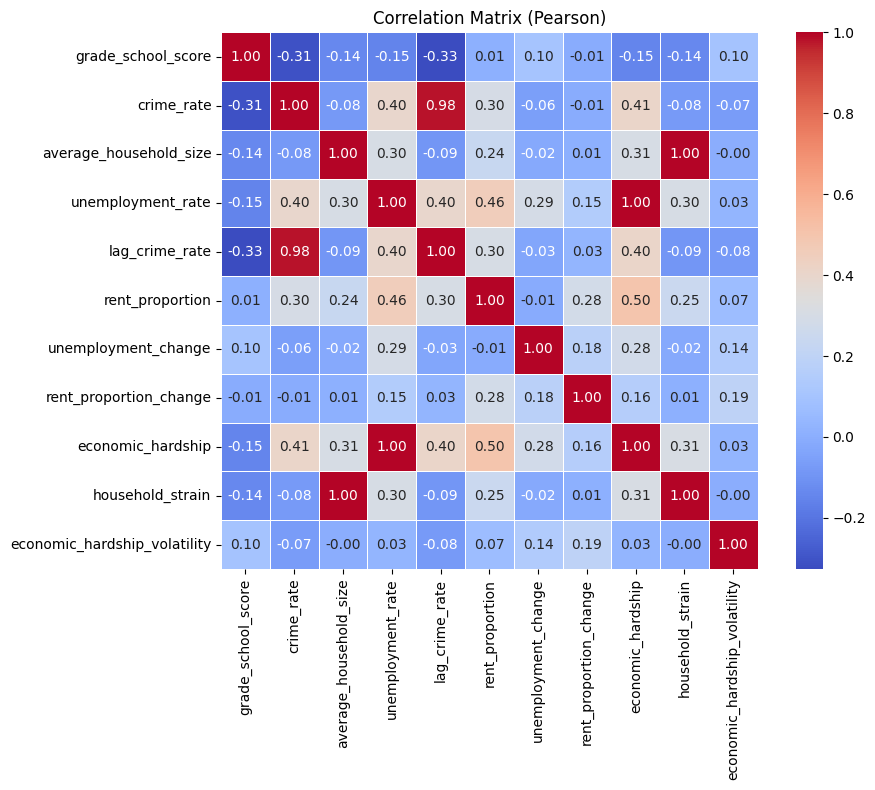

,variable,VIF
0,const,9396.943135
1,grade_school_score,1.222995
2,average_household_size,3270.542538
3,unemployment_rate,1468.024783
4,lag_crime_rate,1.551640
5,rent_proportion,5.996505
6,unemployment_change,1.285562
7,rent_proportion_change,1.204441
8,economic_hardship,1542.785301
9,household_strain,3280.380938


In [6]:

stat_dude.correlation_matrix()
stat_dude.test_multicollinearity()

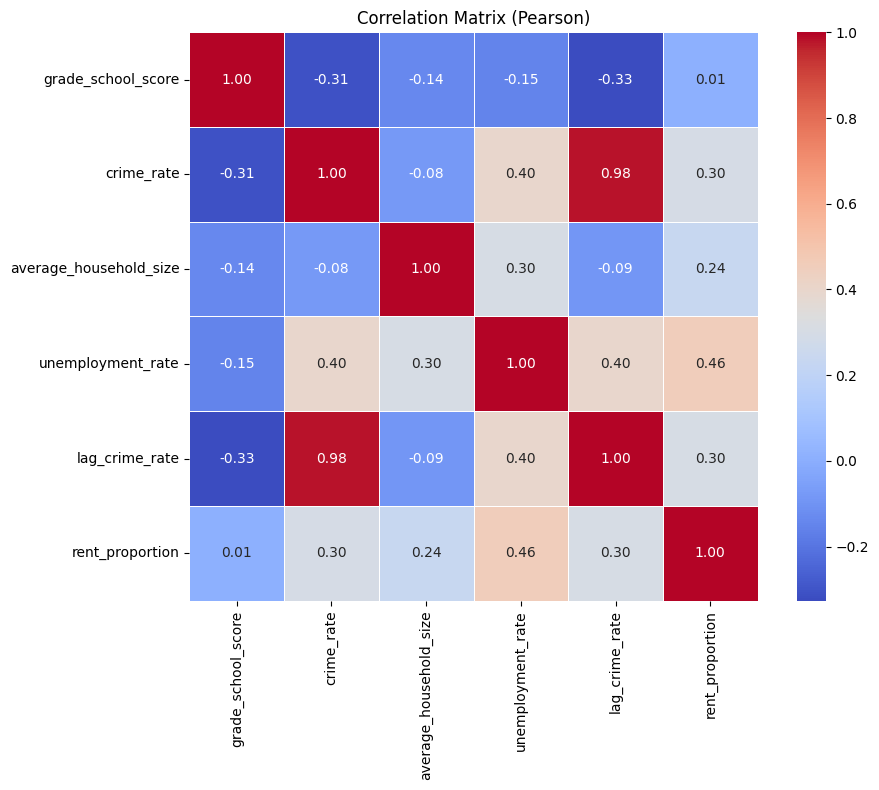

,variable,VIF
0,const,2016.633140
1,grade_school_score,1.195079
2,average_household_size,1.254926
3,unemployment_rate,1.523188
4,lag_crime_rate,1.493592
5,rent_proportion,1.368374


In [7]:
stat_dude_without_interaction = copy.deepcopy(stat_dude)
stat_dude_without_interaction.data = stat_dude_without_interaction.data.drop(columns=["economic_hardship","household_strain","economic_hardship_volatility","rent_proportion_change","unemployment_change"])
stat_dude_without_interaction.correlation_matrix()
stat_dude_without_interaction.test_multicollinearity()



## 3.3: Fitting the Model

## 3.3.1: Fixed Effect

In [8]:
stat_dude.add_polynomial_terms(columns=["unemployment_change","economic_hardship_volatility"],degree=3)
print(stat_dude.data.columns)
model = stat_dude.compare_same_type_models(model_specs=
    [{"name": "No Interaction/Lagged Terms", "indep_vars":["grade_school_score","white_majority","unemployment_rate","average_household_size","rent_proportion"]},
     {"name": "Interaction Terms", "indep_vars":['grade_school_score', 'white_majority', 'average_household_size', 'unemployment_rate', 'lag_crime_rate', 'rent_proportion', 'unemployment_change', 'rent_proportion_change', 'economic_hardship', 'household_strain', 'economic_hardship_volatility']},
     {"name": "Interaction Terms (Removed Insignificant Features)", "indep_vars":['white_majority', 'unemployment_rate', 'lag_crime_rate', 'unemployment_change', 'economic_hardship', 'economic_hardship_volatility']},

     
     
     
     
     
     ]
                                           
                                           
                                           
)

Index(['community_board', 'year', 'grade_school_score', 'crime_rate',
       'white_majority', 'average_household_size', 'unemployment_rate',
       'lag_crime_rate', 'rent_proportion', 'unemployment_change',
       'rent_proportion_change', 'economic_hardship', 'household_strain',
       'economic_hardship_volatility', 'unemployment_change_pow_2',
       'unemployment_change_pow_3', 'economic_hardship_volatility_pow_2',
       'economic_hardship_volatility_pow_3'],
      dtype='object')

*** Heteroskedasticity detected in model 'No Interaction/Lagged Terms' (BP p = 0.0000) ***
Parameter p-values:
const                     0.0000
grade_school_score        0.0000
white_majority.1          0.0755
unemployment_rate         0.0010
average_household_size    0.0134
rent_proportion           0.0000
Name: pvalue, dtype: float64

*** Heteroskedasticity detected in model 'Interaction Terms' (BP p = 0.0000) ***
Parameter p-values:
const                           0.2021
grade_school_score         

## 3.3.2: Random Effect

In [9]:

model = stat_dude.compare_same_type_models(model_specs=
    [{"name": "No Interaction/Lagged Terms", "indep_vars":["grade_school_score","white_majority","unemployment_rate","average_household_size","rent_proportion"]},
     {"name": "Interaction Terms", "indep_vars":['grade_school_score', 'white_majority', 'average_household_size', 'unemployment_rate', 'lag_crime_rate', 'rent_proportion', 'unemployment_change', 'rent_proportion_change', 'economic_hardship', 'household_strain', 'economic_hardship_volatility']},
     {"name": "Interaction Terms (Removed Insignificant Features)", "indep_vars":['grade_school_score','white_majority', 'unemployment_rate', 'lag_crime_rate', 'unemployment_change', 'economic_hardship', 'economic_hardship_volatility']}
     
     
     
     
     
     ],
     effect_type="random")
    
                                           
                                          


*** Heteroskedasticity detected in model 'No Interaction/Lagged Terms' (BP p = 0.0000) ***
Parameter p-values:
const                     0.0000
grade_school_score        0.0000
white_majority.1          0.3350
unemployment_rate         0.0001
average_household_size    0.1300
rent_proportion           0.0002
Name: pvalue, dtype: float64

*** Heteroskedasticity detected in model 'Interaction Terms' (BP p = 0.0000) ***
Parameter p-values:
const                           0.1064
grade_school_score              0.0245
white_majority.1                0.1558
average_household_size          0.4561
unemployment_rate               0.1318
lag_crime_rate                  0.0000
rent_proportion                 0.2322
unemployment_change             0.0000
rent_proportion_change          0.0000
economic_hardship               0.1569
household_strain                0.4574
economic_hardship_volatility    0.0187
Name: pvalue, dtype: float64

*** Heteroskedasticity detected in model 'Interaction Terms (

## 3.3: Evaluation (Hausman Test)

In [10]:
stat_dude.data = stat_dude.data[[stat_dude.entity,stat_dude.time,stat_dude.dep,
    "grade_school_score",
    "white_majority",
    "unemployment_rate",
    "lag_crime_rate",
    "unemployment_change",
    "economic_hardship",
    "economic_hardship_volatility"
]]
model = stat_dude.panel_regression(effect_type="fixed",hausman=True)

Fixed Effects Model (Cluster-Robust SE):
                           PanelOLS Estimation Summary                           
Dep. Variable:             crime_rate   R-squared:                        0.7496
Estimator:                   PanelOLS   R-squared (Between):              0.9288
No. Observations:                1062   R-squared (Within):               0.7496
Date:                Tue, May 27 2025   R-squared (Overall):              0.9070
Time:                        18:29:23   Log-likelihood                    365.72
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      425.98
Entities:                          59   P-value                           0.0000
Avg Obs:                       18.000   Distribution:                   F(7,996)
Min Obs:                       18.000                                           
Max Obs:                       18.000   F-statistic (robust):      

## 3.4: Residual Plots

                          PanelOLS Estimation Summary                           
Dep. Variable:             crime_rate   R-squared:                        0.7496
Estimator:                   PanelOLS   R-squared (Between):              0.9288
No. Observations:                1062   R-squared (Within):               0.7496
Date:                Tue, May 27 2025   R-squared (Overall):              0.9070
Time:                        18:29:23   Log-likelihood                    365.72
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      425.98
Entities:                          59   P-value                           0.0000
Avg Obs:                       18.000   Distribution:                   F(7,996)
Min Obs:                       18.000                                           
Max Obs:                       18.000   F-statistic (robust):             283.92
                            

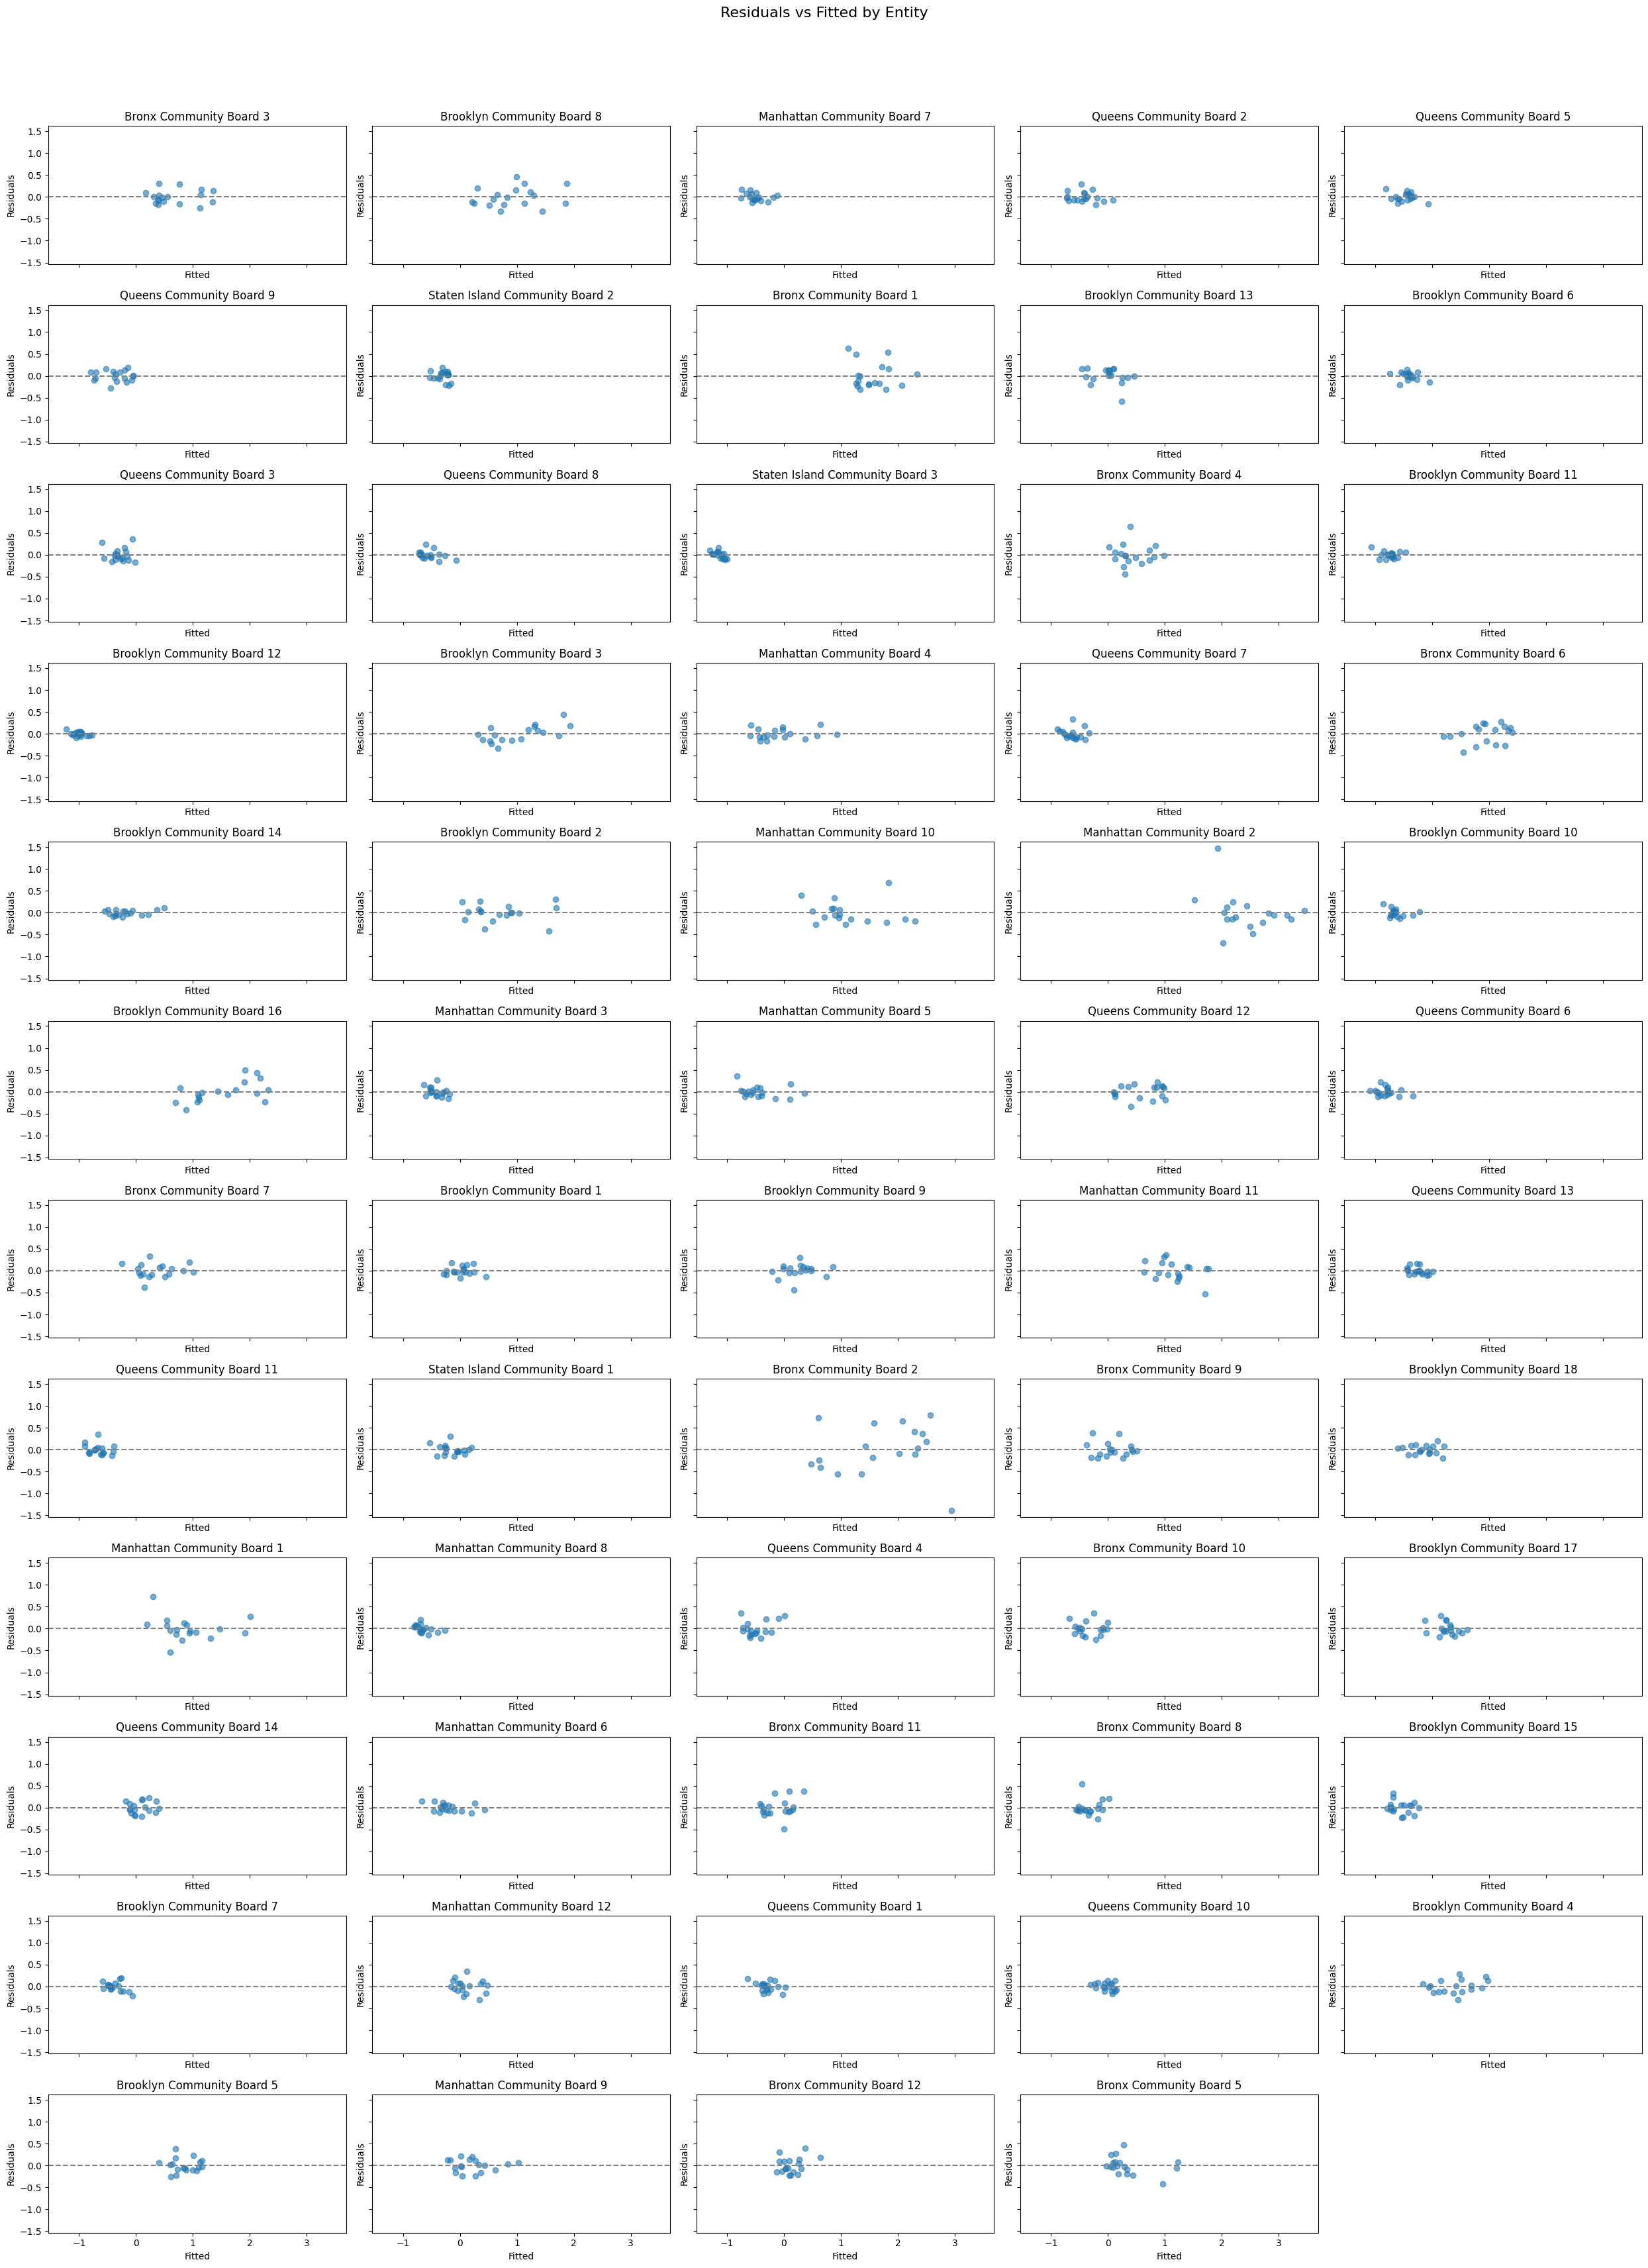

In [11]:
model = stat_dude.fit_and_plot_residuals()
